In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.db import *
from scripts.plots import *
from scripts.stats import *
from scripts.statsTransferencia import *
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

resumen = dataNumerica()
data = pd.DataFrame.from_dict(resumen, orient='index')

#Trasnformamos los valores que interesan en columnas (Por ahora voy a hacer todo en angulos)
dataTest = pd.DataFrame()
dataTestI = pd.DataFrame()
dataTestF = pd.DataFrame()
for i, col in enumerate(["P30", "P60", "P120","P150","A30","A60","A120","A150"]):
    dataTestI["I"+col] = data['TestInicialAngulos'].map(lambda x: x[i])
    dataTest["I"+col] = data['TestInicialAngulos'].map(lambda x: x[i])
for i, col in enumerate(["P30", "P60", "P120","P150","A30","A60","A120","A150"]):
    dataTestF["F"+col] = data['TestFinalAngulos'].map(lambda x: x[i])
    dataTest["F"+col] = data['TestFinalAngulos'].map(lambda x: x[i]) 

/home/ionatan/Gits/IPyVisound/scripts/statsTransferencia.py:536: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame
  dataByAlias[cts.P_FaseActiva].replace('ExperimentoCompleto', 'TestFinal', inplace=True)
/home/ionatan/Gits/IPyVisound/scripts/statsTransferencia.py:508: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame
  dataByAlias[cts.P_OrientacionEntrenamiento].replace('A30', 'P30', inplace=True)
/home/ionatan/Gits/IPyVisound/scripts/statsTransferencia.py:510: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame
  dataByAlias[cts.P_OrientacionEntrenamiento].replace('P30', 'CONTROL', inplace=True)


Anova entre umbrales paralelismo: 0.00200715611003
Anova entre umbrales paralelismo (sin P60): 0.240223355667
Anova entre umbrales angulos: 0.119043335688


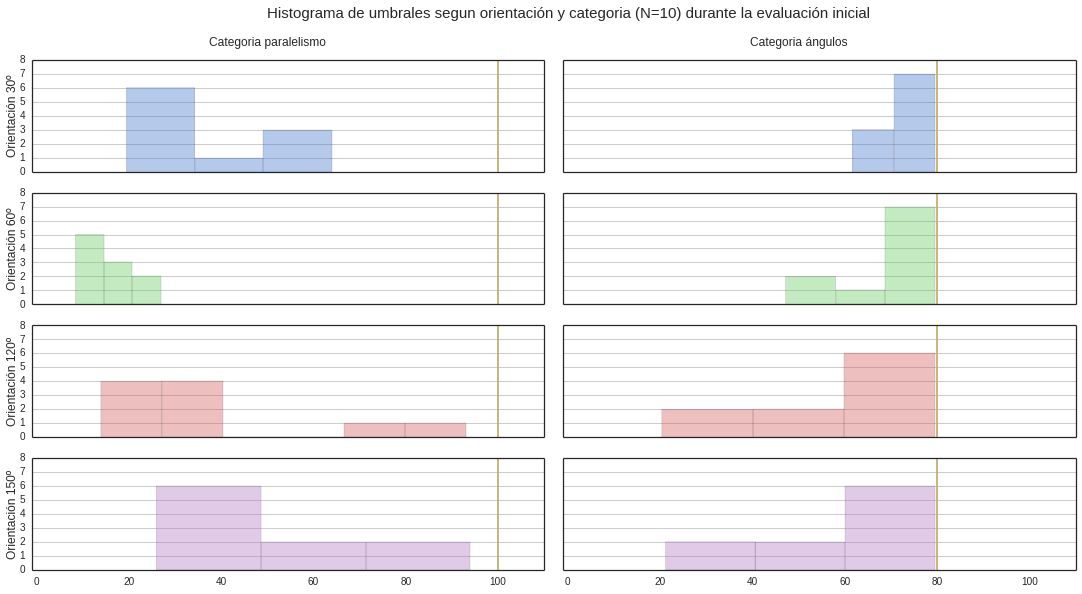

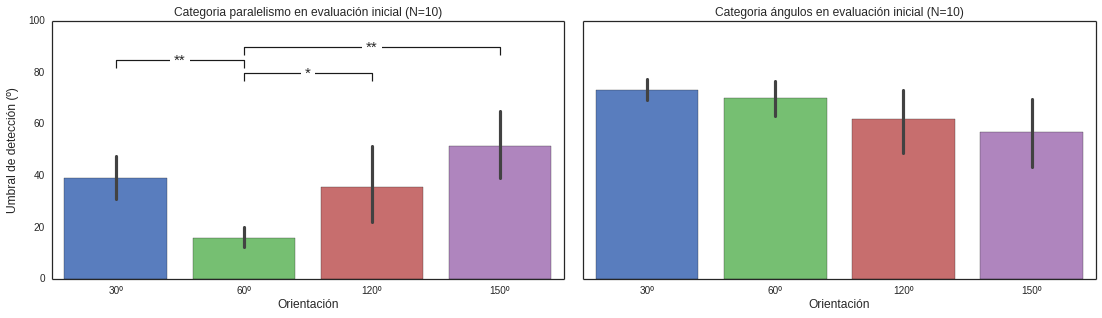

In [103]:
# Graficos de histogramas para nivel inicial completo
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.despine(left=True)

fig, ax = plt.subplots(4,2, sharex=True, sharey=True)
fig.set_size_inches(15,7.5)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

cosas = dataTest[['IP30','IP60','IP120','IP150']]
for i, col_id in enumerate(cosas.columns):
    sns.distplot(cosas[col_id], axlabel='', ax=ax[i,0], color=sns.color_palette()[i], kde=False)
    ax[i,0].vlines(100,0,8,sns.color_palette()[4])
cosas = dataTest[['IA30','IA60','IA120','IA150']]
for i, col_id in enumerate(cosas.columns):
    sns.distplot(cosas[col_id], axlabel='', ax=ax[i,1], color=sns.color_palette()[i], kde=False)
    ax[i,1].vlines(80,0,8,sns.color_palette()[4])
    
ax[3,0].set_xlim([-1, 110])
ax[0,0].set_ylim([0, 8])
ax[0,1].text(0,11,'Histograma de umbrales segun orientación y categoria (N=10) durante la evaluación inicial', fontsize=15, ha='center')
ax[0,1].text(50,9,'Categoria ángulos', fontsize=12, ha='center')
ax[0,0].text(50,9,'Categoria paralelismo', fontsize=12, ha='center')
ax[0,0].text(-5,4,'Orientación 30º', fontsize=12, ha='center', va='center', rotation=90)
ax[1,0].text(-5,4,'Orientación 60º', fontsize=12, ha='center', va='center', rotation=90)
ax[2,0].text(-5,4,'Orientación 120º', fontsize=12, ha='center', va='center', rotation=90)
ax[3,0].text(-5,4,'Orientación 150º', fontsize=12, ha='center', va='center', rotation=90)


for axis in ax:
    for axi in axis:
        axi.yaxis.grid(True)
fig.savefig('./Images/TransferenciaInicialHisto', bbox_inches='tight')

# ahora vamos a hacer los promedios 
fig, ax = plt.subplots(1,2, sharey = True)
fig.set_size_inches(15,4)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
cosas = dataTest[['IP30','IP60','IP120','IP150']]
cosas.columns = ['30º','60º','120º','150º']
sns.barplot(data=cosas, ax=ax[0])
cosas = dataTest[['IA30','IA60','IA120','IA150']]
cosas.columns = ['30º','60º','120º','150º']
sns.barplot(data=cosas, ax=ax[1])

ax[0].set_ylim([0, 100])
ax[0].set_title('Categoria paralelismo en evaluación inicial (N=10)')
ax[1].set_title('Categoria ángulos en evaluación inicial (N=10)')
ax[0].text(-0.8,50,'Umbral de detección (º)', fontsize=12, ha='center', va='center', rotation=90)
ax[0].text(1.5,-10,'Orientación', fontsize=12, ha='center', va='center')
ax[1].text(1.5,-10,'Orientación', fontsize=12, ha='center', va='center')

# Importamos cosas para el analsisi de significancia
from scipy import stats  
import scipy
from matplotlib.markers import TICKDOWN
def significance_bar(ax,height,p,start=0,end=1,linewidth = 1.2,markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    if p>=0.05:
        displaystring = r'n.s.'
    elif p<0.0001:
        displaystring = r'***'
    elif p<0.001:
        displaystring = r'**'
    else:
        displaystring = r'*'
    # draw a line with downticks at the ends
    ax.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    ax.text(0.5*(start+end),height,displaystring,ha = 'center',va='center',bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)
    
# hacemos un anova para paralelismo
cosas = dataTest[['IP30','IP60','IP120','IP150']]
print ('Anova entre umbrales paralelismo: '+ str(stats.f_oneway(cosas['IP30'], cosas['IP60'], cosas['IP120'], cosas['IP150'])[1]))
# hacemos un anova para paralelismo excluyendo P60
cosas = dataTest[['IP30','IP120','IP150']]
print ('Anova entre umbrales paralelismo (sin P60): '+ str(stats.f_oneway(cosas['IP30'], cosas['IP120'], cosas['IP150'])[1]))

cosas = dataTest[['IA30','IA60','IA120','IA150']]
print ('Anova entre umbrales angulos: '+ str(stats.f_oneway(cosas['IA30'], cosas['IA60'], cosas['IA120'], cosas['IA150'])[1]))
# Como da solo en paralelismo valido hacemos ahi los ttest relacionados

cosas = dataTest[['IP30','IP60','IP120','IP150']]
pares = [[0,1,'IP30','IP60',0],[1,2,'IP60','IP120',-5],[1,3,'IP60','IP150',5]]
for par in pares:
    f, p = scipy.stats.ttest_rel(cosas[par[2]],cosas[par[3]])
    significance_bar (ax[0],85+par[4],p,par[0],par[1])

fig.savefig('./Images/TransferenciaInicialMedias', bbox_inches='tight')

Vamos a comparar ahora entre los sujetos, con tres graficos uno para A30, uno para P30 y uno para el promedio general. No vamos a realizar ajustes, solo histograma con un alpha 0.5 para los iniciales y otro de 1 para los finales

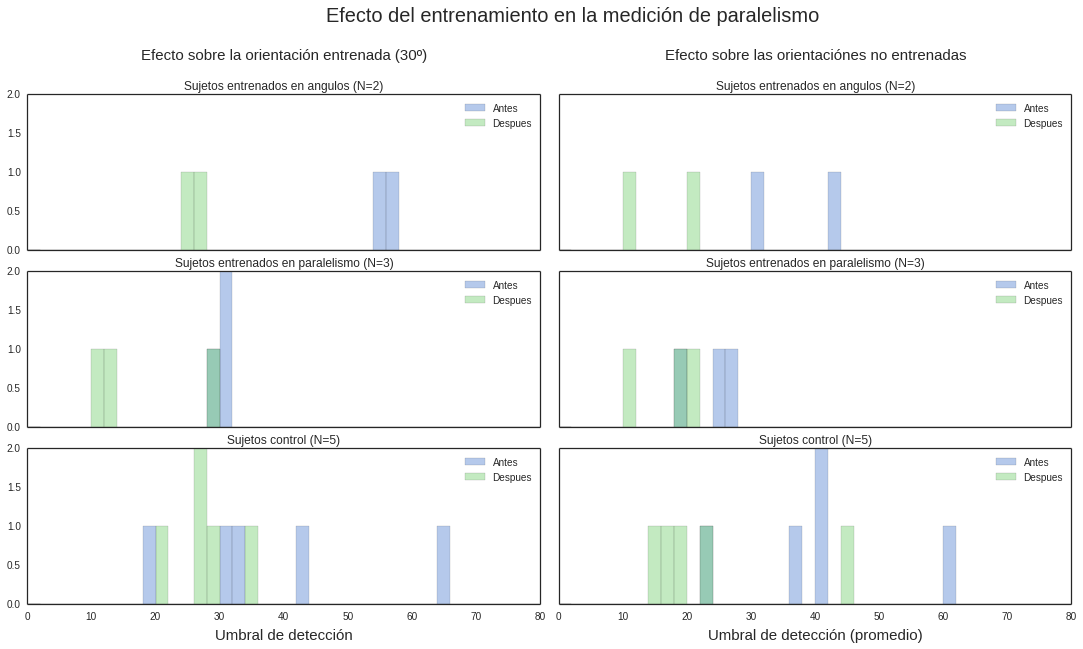

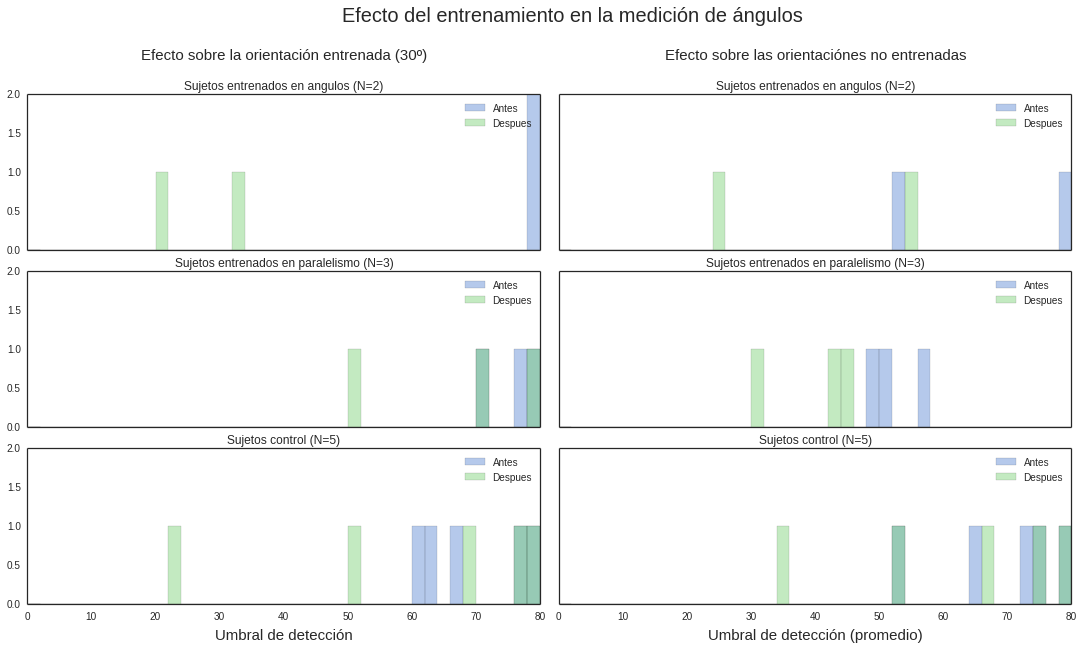

In [218]:
# Graficos de histogramas para nivel inicial completo
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.despine(left=True)

fig, ax = plt.subplots(3,2, sharex=True, sharey=True)
fig.set_size_inches(15,7.5)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Vamos con el grafico comparando Paralelismo 
cosasInciales = []
cosasInciales = cosasInciales + [dataTest['IP30'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasInciales = cosasInciales + [dataTest['IP30'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasInciales = cosasInciales + [dataTest['IP30'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control
cosasFinales = []
cosasFinales = cosasFinales + [dataTest['FP30'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasFinales = cosasFinales + [dataTest['FP30'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasFinales = cosasFinales + [dataTest['FP30'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control

# Hacemos el promedio de los P que no se entrenaron
dataTest['PINoEntrenado'] = dataTest[['IP60','IP120','IP150']].mean(axis=1)
dataTest['PFNoEntrenado'] = dataTest[['FP60','FP120','FP150']].mean(axis=1)
cosasIncialesNE = []
cosasIncialesNE = cosasIncialesNE + [dataTest['PINoEntrenado'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasIncialesNE = cosasIncialesNE + [dataTest['PINoEntrenado'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasIncialesNE = cosasIncialesNE + [dataTest['PINoEntrenado'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control
cosasFinalesNE = []
cosasFinalesNE = cosasFinalesNE + [dataTest['PFNoEntrenado'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasFinalesNE = cosasFinalesNE + [dataTest['PFNoEntrenado'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasFinalesNE = cosasFinalesNE + [dataTest['PFNoEntrenado'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control

bins = range(0,100,2)
titulos = ['Sujetos entrenados en angulos (N=2)','Sujetos entrenados en paralelismo (N=3)', 'Sujetos control (N=5)']
for i, elemento in enumerate(cosasInciales):
    sns.distplot(elemento, axlabel='', ax=ax[i,0], kde=False, bins=bins, label='Antes')
    ax[i,0].set_xlim([0, 80])
for i, elemento in enumerate(cosasFinales):
    sns.distplot(elemento, axlabel='', ax=ax[i,0], kde=False, bins=bins, label='Despues')
    ax[i,0].legend()
    ax[i,0].set_title(titulos[i])
for i, elemento in enumerate(cosasIncialesNE):
    sns.distplot(elemento, axlabel='', ax=ax[i,1], kde=False, bins=bins, label='Antes')
    ax[i,1].set_xlim([0, 80])
for i, elemento in enumerate(cosasFinalesNE):
    sns.distplot(elemento, axlabel='', ax=ax[i,1], kde=False, bins=bins, label='Despues')
    ax[i,1].legend()
    ax[i,1].set_title(titulos[i])

ax[0,0].text(85,3,'Efecto del entrenamiento en la medición de paralelismo', fontsize=20, ha='center', va='center')
ax[0,0].text(40,2.5,'Efecto sobre la orientación entrenada (30º)', fontsize=15, ha='center', va='center')
ax[0,1].text(40,2.5,'Efecto sobre las orientaciónes no entrenadas', fontsize=15, ha='center', va='center')
ax[2,0].text(40,-0.4,'Umbral de detección', fontsize=15, ha='center', va='center')
ax[2,1].text(40,-0.4,'Umbral de detección (promedio)', fontsize=15, ha='center', va='center')

fig.savefig('./Images/TransferenciaParalelismo', bbox_inches='tight')



#
# Repetimos todo para angulos
#


# Graficos de histogramas para nivel inicial completo
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

fig, ax = plt.subplots(3,2, sharex=True, sharey=True)
fig.set_size_inches(15,7.5)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Vamos con el grafico comparando Paralelismo 
cosasInciales = []
cosasInciales = cosasInciales + [dataTest['IA30'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasInciales = cosasInciales + [dataTest['IA30'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasInciales = cosasInciales + [dataTest['IA30'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control
cosasFinales = []
cosasFinales = cosasFinales + [dataTest['FA30'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasFinales = cosasFinales + [dataTest['FA30'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasFinales = cosasFinales + [dataTest['FA30'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control

# Hacemos el promedio de los P que no se entrenaron
dataTest['AINoEntrenado'] = dataTest[['IA60','IA120','IA150']].mean(axis=1)
dataTest['AFNoEntrenado'] = dataTest[['FA60','FA120','FA150']].mean(axis=1)
cosasIncialesNE = []
cosasIncialesNE = cosasIncialesNE + [dataTest['AINoEntrenado'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasIncialesNE = cosasIncialesNE + [dataTest['AINoEntrenado'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasIncialesNE = cosasIncialesNE + [dataTest['AINoEntrenado'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control
cosasFinalesNE = []
cosasFinalesNE = cosasFinalesNE + [dataTest['AFNoEntrenado'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasFinalesNE = cosasFinalesNE + [dataTest['AFNoEntrenado'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasFinalesNE = cosasFinalesNE + [dataTest['AFNoEntrenado'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control

bins = range(0,100,2)
titulos = ['Sujetos entrenados en angulos (N=2)','Sujetos entrenados en paralelismo (N=3)', 'Sujetos control (N=5)']
for i, elemento in enumerate(cosasInciales):
    sns.distplot(elemento, axlabel='', ax=ax[i,0], kde=False, bins=bins, label='Antes')
    ax[i,0].set_xlim([0, 80])
for i, elemento in enumerate(cosasFinales):
    sns.distplot(elemento, axlabel='', ax=ax[i,0], kde=False, bins=bins, label='Despues')
    ax[i,0].legend()
    ax[i,0].set_title(titulos[i])
for i, elemento in enumerate(cosasIncialesNE):
    sns.distplot(elemento, axlabel='', ax=ax[i,1], kde=False, bins=bins, label='Antes')
    ax[i,1].set_xlim([0, 80])
for i, elemento in enumerate(cosasFinalesNE):
    sns.distplot(elemento, axlabel='', ax=ax[i,1], kde=False, bins=bins, label='Despues')
    ax[i,1].legend()
    ax[i,1].set_title(titulos[i])

ax[0,0].text(85,3,'Efecto del entrenamiento en la medición de ángulos', fontsize=20, ha='center', va='center')
ax[0,0].text(40,2.5,'Efecto sobre la orientación entrenada (30º)', fontsize=15, ha='center', va='center')
ax[0,1].text(40,2.5,'Efecto sobre las orientaciónes no entrenadas', fontsize=15, ha='center', va='center')
ax[2,0].text(40,-0.4,'Umbral de detección', fontsize=15, ha='center', va='center')
ax[2,1].text(40,-0.4,'Umbral de detección (promedio)', fontsize=15, ha='center', va='center')

fig.savefig('./Images/TransferenciaAngulos', bbox_inches='tight')











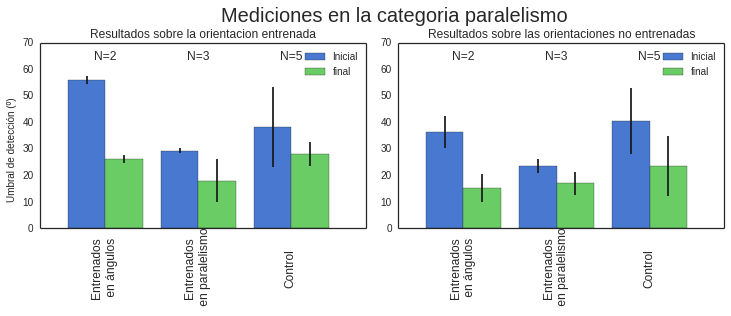

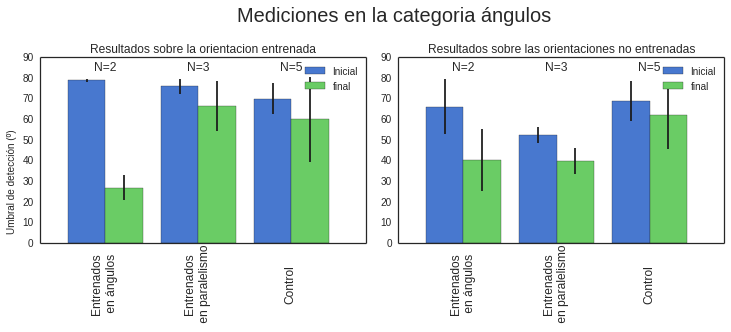

In [293]:
import numpy as np

# ahora vamos a hacer los promedios 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,3)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Vamos con el grafico de paralelismo

# Vamos con el grafico comparando Paralelismo 
cosasInciales = []
cosasInciales = cosasInciales + [dataTest['IP30'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasInciales = cosasInciales + [dataTest['IP30'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasInciales = cosasInciales + [dataTest['IP30'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control
cosasFinales = []
cosasFinales = cosasFinales + [dataTest['FP30'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasFinales = cosasFinales + [dataTest['FP30'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasFinales = cosasFinales + [dataTest['FP30'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control

# Hacemos el promedio de los P que no se entrenaron
dataTest['PINoEntrenado'] = dataTest[['IP60','IP120','IP150']].mean(axis=1)
dataTest['PFNoEntrenado'] = dataTest[['FP60','FP120','FP150']].mean(axis=1)
cosasIncialesNE = []
cosasIncialesNE = cosasIncialesNE + [dataTest['PINoEntrenado'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasIncialesNE = cosasIncialesNE + [dataTest['PINoEntrenado'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasIncialesNE = cosasIncialesNE + [dataTest['PINoEntrenado'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control
cosasFinalesNE = []
cosasFinalesNE = cosasFinalesNE + [dataTest['PFNoEntrenado'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasFinalesNE = cosasFinalesNE + [dataTest['PFNoEntrenado'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasFinalesNE = cosasFinalesNE + [dataTest['PFNoEntrenado'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control

width = 0.4
for i, datos in enumerate(zip(cosasInciales,cosasFinales)):
    if i==1:
        ax[0].bar(i-width/2, np.mean(datos[0]), width=width, color=sns.color_palette()[0], yerr=np.std(datos[0]), ecolor='k', label='Inicial')
        ax[0].bar(i+0.4-width/2, np.mean(datos[1]), width=width, color=sns.color_palette()[1], yerr=np.std(datos[1]), ecolor='k', label='final')
    else:
        ax[0].bar(i-width/2, np.mean(datos[0]), width=width, color=sns.color_palette()[0], yerr=np.std(datos[0]), ecolor='k')
        ax[0].bar(i+0.4-width/2, np.mean(datos[1]), width=width, color=sns.color_palette()[1], yerr=np.std(datos[1]), ecolor='k')

for i, datos in enumerate(zip(cosasIncialesNE,cosasFinalesNE)):
    if i==1:
        ax[1].bar(i-width/2, np.mean(datos[0]), width=width, color=sns.color_palette()[0], yerr=np.std(datos[0]), ecolor='k', label='Inicial')
        ax[1].bar(i+0.4-width/2, np.mean(datos[1]), width=width, color=sns.color_palette()[1], yerr=np.std(datos[1]), ecolor='k', label='final')
    else:
        ax[1].bar(i-width/2, np.mean(datos[0]), width=width, color=sns.color_palette()[0], yerr=np.std(datos[0]), ecolor='k')
        ax[1].bar(i+0.4-width/2, np.mean(datos[1]), width=width, color=sns.color_palette()[1], yerr=np.std(datos[1]), ecolor='k')

ax[1].legend()
ax[0].legend()
ax[0].set_title('Resultados sobre la orientacion entrenada',fontsize=12)
ax[1].set_title('Resultados sobre las orientaciones no entrenadas', fontsize=12)
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

ax[0].set_ylim([0,70])
ax[1].set_ylim([0,70])

ax[0].text(-0.8,30,'Umbral de detección (º)', fontsize=10, ha='center', va='center', rotation=90)

ax[0].text(0.2,-15,'Entrenados \n en ángulos', fontsize=12, ha='center', va='center', rotation=90)
ax[0].text(0.2,65,'N=2', fontsize=12, ha='center', va='center')

ax[0].text(1.2,-15,'Entrenados \n en paralelismo', fontsize=12, ha='center', va='center', rotation=90)
ax[0].text(1.2,65,'N=3', fontsize=12, ha='center', va='center')

ax[0].text(2.2,-15,'Control', fontsize=12, ha='center', va='center', rotation=90)
ax[0].text(2.2,65,'N=5', fontsize=12, ha='center', va='center')

ax[1].text(0.2,-15,'Entrenados \n en ángulos', fontsize=12, ha='center', va='center', rotation=90)
ax[1].text(0.2,65,'N=2', fontsize=12, ha='center', va='center')

ax[1].text(1.2,-15,'Entrenados \n en paralelismo', fontsize=12, ha='center', va='center', rotation=90)
ax[1].text(1.2,65,'N=3', fontsize=12, ha='center', va='center')

ax[1].text(2.2,-15,'Control', fontsize=12, ha='center', va='center', rotation=90)
ax[1].text(2.2,65,'N=5', fontsize=12, ha='center', va='center')


ax[0].text(3.3,80,'Mediciones en la categoria paralelismo',fontsize=20, ha='center', va='center')

fig.savefig('./Images/TransferenciaParalelismoBarras', bbox_inches='tight')


# ahora vamos a hacer los promedios 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,3)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Vamos con el grafico de paralelismo

# Vamos con el grafico comparando Paralelismo 
cosasInciales = []
cosasInciales = cosasInciales + [dataTest['IA30'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasInciales = cosasInciales + [dataTest['IA30'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasInciales = cosasInciales + [dataTest['IA30'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control
cosasFinales = []
cosasFinales = cosasFinales + [dataTest['FA30'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasFinales = cosasFinales + [dataTest['FA30'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasFinales = cosasFinales + [dataTest['FA30'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control

# Hacemos el promedio de los P que no se entrenaron
dataTest['AINoEntrenado'] = dataTest[['IA60','IA120','IA150']].mean(axis=1)
dataTest['AFNoEntrenado'] = dataTest[['FA60','FA120','FA150']].mean(axis=1)
cosasIncialesNE = []
cosasIncialesNE = cosasIncialesNE + [dataTest['AINoEntrenado'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasIncialesNE = cosasIncialesNE + [dataTest['AINoEntrenado'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasIncialesNE = cosasIncialesNE + [dataTest['AINoEntrenado'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control
cosasFinalesNE = []
cosasFinalesNE = cosasFinalesNE + [dataTest['AFNoEntrenado'].tolist()[0:2]] # Esto es lo que corresponde a los sujetos que entrenaron angulos
cosasFinalesNE = cosasFinalesNE + [dataTest['AFNoEntrenado'].tolist()[2:5]] # Esto es lo que corresponde a los sujetos que entrenaron paralelismo
cosasFinalesNE = cosasFinalesNE + [dataTest['AFNoEntrenado'].tolist()[5:10]] # Esto es lo que corresponde a los sujetos que entrenaron control

width = 0.4
for i, datos in enumerate(zip(cosasInciales,cosasFinales)):
    if i==1:
        ax[0].bar(i-width/2, np.mean(datos[0]), width=width, color=sns.color_palette()[0], yerr=np.std(datos[0]), ecolor='k', label='Inicial')
        ax[0].bar(i+0.4-width/2, np.mean(datos[1]), width=width, color=sns.color_palette()[1], yerr=np.std(datos[1]), ecolor='k', label='final')
    else:
        ax[0].bar(i-width/2, np.mean(datos[0]), width=width, color=sns.color_palette()[0], yerr=np.std(datos[0]), ecolor='k')
        ax[0].bar(i+0.4-width/2, np.mean(datos[1]), width=width, color=sns.color_palette()[1], yerr=np.std(datos[1]), ecolor='k')

for i, datos in enumerate(zip(cosasIncialesNE,cosasFinalesNE)):
    if i==1:
        ax[1].bar(i-width/2, np.mean(datos[0]), width=width, color=sns.color_palette()[0], yerr=np.std(datos[0]), ecolor='k', label='Inicial')
        ax[1].bar(i+0.4-width/2, np.mean(datos[1]), width=width, color=sns.color_palette()[1], yerr=np.std(datos[1]), ecolor='k', label='final')
    else:
        ax[1].bar(i-width/2, np.mean(datos[0]), width=width, color=sns.color_palette()[0], yerr=np.std(datos[0]), ecolor='k')
        ax[1].bar(i+0.4-width/2, np.mean(datos[1]), width=width, color=sns.color_palette()[1], yerr=np.std(datos[1]), ecolor='k')

ax[1].legend()
ax[0].legend()
ax[0].set_title('Resultados sobre la orientacion entrenada',fontsize=12)
ax[1].set_title('Resultados sobre las orientaciones no entrenadas', fontsize=12)
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[0].text(-0.8,30,'Umbral de detección (º)', fontsize=10, ha='center', va='center', rotation=90)

ax[0].set_ylim([0,90])
ax[1].set_ylim([0,90])

ax[0].text(0.2,-20,'Entrenados \n en ángulos', fontsize=12, ha='center', va='center', rotation=90)
ax[0].text(0.2,85,'N=2', fontsize=12, ha='center', va='center')

ax[0].text(1.2,-20,'Entrenados \n en paralelismo', fontsize=12, ha='center', va='center', rotation=90)
ax[0].text(1.2,85,'N=3', fontsize=12, ha='center', va='center')

ax[0].text(2.2,-20,'Control', fontsize=12, ha='center', va='center', rotation=90)
ax[0].text(2.2,85,'N=5', fontsize=12, ha='center', va='center')

ax[1].text(0.2,-20,'Entrenados \n en ángulos', fontsize=12, ha='center', va='center', rotation=90)
ax[1].text(0.2,85,'N=2', fontsize=12, ha='center', va='center')

ax[1].text(1.2,-20,'Entrenados \n en paralelismo', fontsize=12, ha='center', va='center', rotation=90)
ax[1].text(1.2,85,'N=3', fontsize=12, ha='center', va='center')

ax[1].text(2.2,-20,'Control', fontsize=12, ha='center', va='center', rotation=90)
ax[1].text(2.2,85,'N=5', fontsize=12, ha='center', va='center')

ax[0].text(3.3,110,'Mediciones en la categoria ángulos',fontsize=20, ha='center', va='center')

fig.savefig('./Images/TransferenciaAngulosBarras', bbox_inches='tight')


In [217]:
datos

([57.499999999999993, 54.500000000000007],
 [27.599999999999998, 24.800000000000001])

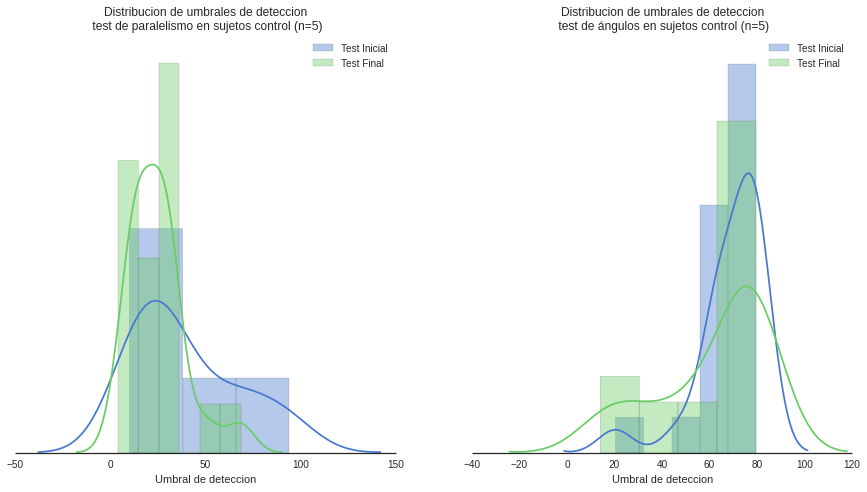

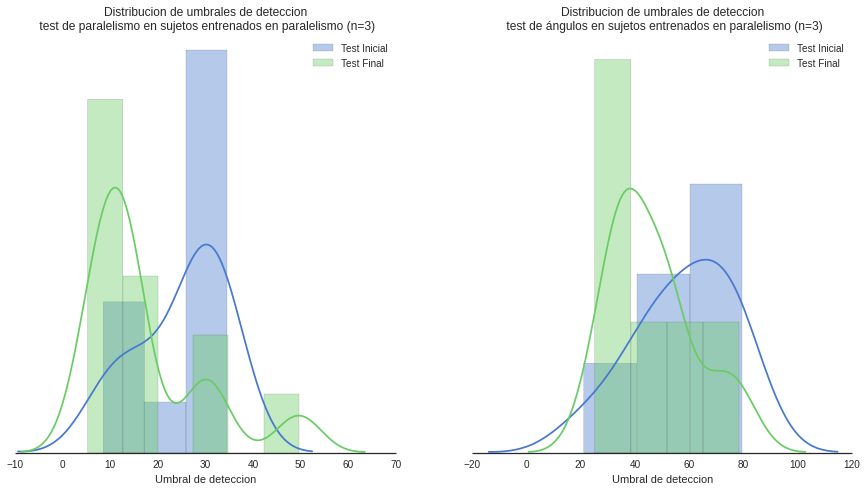

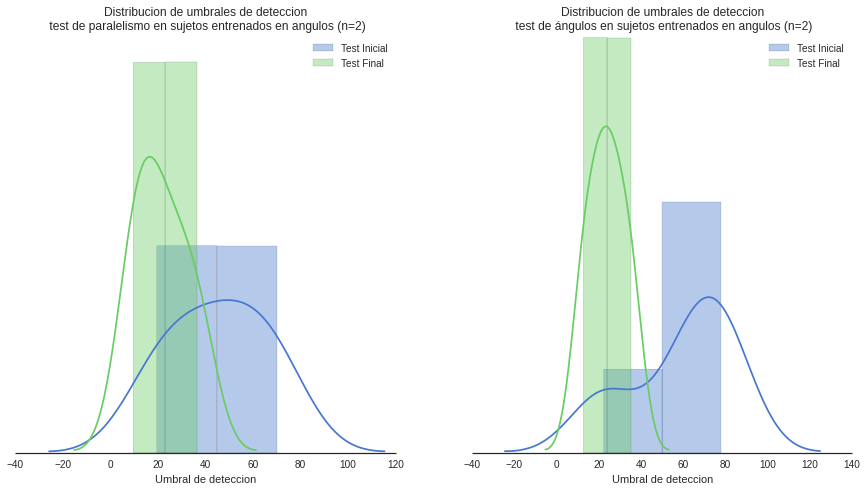

In [24]:
# Graficos de histogramas para comparar control antes y despues

sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.despine(left=True)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7.5)

colors = sns.color_palette()

# Paralelismo
PAntes = dataTest[['IP30','IP60','IP120','IP150']].iloc[5:10].stack().reset_index()[0].tolist()
PDespues = dataTest[['FP30','FP60','FP120','FP150']].iloc[5:10].stack().reset_index()[0].tolist()

sns.distplot(PAntes, label='Test Inicial', axlabel='Umbral de deteccion', ax=ax[0], hist=True)
sns.distplot(PDespues, label='Test Final', ax=ax[0], hist=True, axlabel='Umbral de deteccion')

# Angulos
AAntes = dataTest[['IA30','IA60','IA120','IA150']].iloc[5:10].stack().reset_index()[0].tolist()
ADespues = dataTest[['FA30','FA60','FA120','FA150']].iloc[5:10].stack().reset_index()[0].tolist()

sns.distplot(AAntes, label='Test Inicial', axlabel='Umbral de deteccion', ax=ax[1], hist=True)
sns.distplot(ADespues, label='Test Final', ax=ax[1], hist=True, axlabel='Umbral de deteccion')

ax[0].set_title('Distribucion de umbrales de deteccion \n test de paralelismo en sujetos control (n=5)')
ax[1].set_title('Distribucion de umbrales de deteccion \n test de ángulos en sujetos control (n=5)')

for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].legend()
    
fig.savefig('./Images/TransferenciaHistogramasControlAntesVsDespues', bbox_inches='tight')


#
# Para entrenados en paralelismo
#


# Graficos de histogramas para comparar control antes y despues

sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.despine(left=True)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7.5)

colors = sns.color_palette()

# Paralelismo
PAntes = dataTest[['IP30','IP60','IP120','IP150']].iloc[2:5].stack().reset_index()[0].tolist()
PDespues = dataTest[['FP30','FP60','FP120','FP150']].iloc[2:5].stack().reset_index()[0].tolist()

sns.distplot(PAntes, label='Test Inicial', axlabel='Umbral de deteccion', ax=ax[0], hist=True)
sns.distplot(PDespues, label='Test Final', ax=ax[0], hist=True, axlabel='Umbral de deteccion')

# Angulos
AAntes = dataTest[['IA30','IA60','IA120','IA150']].iloc[2:5].stack().reset_index()[0].tolist()
ADespues = dataTest[['FA30','FA60','FA120','FA150']].iloc[2:5].stack().reset_index()[0].tolist()

sns.distplot(AAntes, label='Test Inicial', axlabel='Umbral de deteccion', ax=ax[1], hist=True)
sns.distplot(ADespues, label='Test Final', ax=ax[1], hist=True, axlabel='Umbral de deteccion')

ax[0].set_title('Distribucion de umbrales de deteccion \n test de paralelismo en sujetos entrenados en paralelismo (n=3)')
ax[1].set_title('Distribucion de umbrales de deteccion \n test de ángulos en sujetos entrenados en paralelismo (n=3)')

for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].legend()
    
fig.savefig('./Images/TransferenciaHistogramasParalelismoAntesVsDespues', bbox_inches='tight')


#
# Para entrenados en angulos
#


# Graficos de histogramas para comparar control antes y despues

sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.despine(left=True)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7.5)

colors = sns.color_palette()

# Paralelismo
PAntes = dataTest[['IP30','IP60','IP120','IP150']].iloc[1:2].stack().reset_index()[0].tolist()
PDespues = dataTest[['FP30','FP60','FP120','FP150']].iloc[1:2].stack().reset_index()[0].tolist()

sns.distplot(PAntes, label='Test Inicial', axlabel='Umbral de deteccion', ax=ax[0], hist=True)
sns.distplot(PDespues, label='Test Final', ax=ax[0], hist=True, axlabel='Umbral de deteccion')

# Angulos
AAntes = dataTest[['IA30','IA60','IA120','IA150']].iloc[1:2].stack().reset_index()[0].tolist()
ADespues = dataTest[['FA30','FA60','FA120','FA150']].iloc[1:2].stack().reset_index()[0].tolist()

sns.distplot(AAntes, label='Test Inicial', axlabel='Umbral de deteccion', ax=ax[1], hist=True)
sns.distplot(ADespues, label='Test Final', ax=ax[1], hist=True, axlabel='Umbral de deteccion')

ax[0].set_title('Distribucion de umbrales de deteccion \n test de paralelismo en sujetos entrenados en angulos (n=2)')
ax[1].set_title('Distribucion de umbrales de deteccion \n test de ángulos en sujetos entrenados en angulos (n=2)')

for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].legend()
    
fig.savefig('./Images/TransferenciaHistogramasAngulosAntesVsDespues', bbox_inches='tight')

In [3]:
dataTestI

,IP30,IP60,IP120,IP150,IA30,IA60,IA120,IA150
Sujeto01,57.5,17.0,34.0,39.5,79.6,78.4,79.6,79.6
Sujeto02,54.5,19.5,70.0,37.5,78.0,76.0,59.6,22.4
Sujeto03,30.0,18.0,34.5,26.0,70.8,77.2,48.4,21.2
Sujeto04,28.0,10.5,28.5,34.5,79.6,68.8,61.6,42.0
Sujeto05,30.0,8.5,16.5,34.5,77.2,56.8,38.0,55.6
Sujeto06,64.0,27.0,30.0,68.0,63.2,78.4,79.2,79.6
Sujeto07,19.5,10.0,93.0,80.0,77.6,79.6,74.4,62.0
Sujeto08,32.0,13.0,14.0,40.0,67.6,47.2,79.6,66.0
Sujeto09,31.5,25.5,22.0,63.0,61.6,61.6,20.4,74.8
Sujeto10,43.5,11.0,15.0,94.0,79.6,79.6,79.6,67.6
